# CNIC-VD + Correlator investigation
Basic data path test with CNIC VD to simulate a sky source observation and correlator data captured

Base code showing the implementation can be found: Perentie test case PTC #11

## Import packages

In [1]:
# %pip install --user --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple \
# %pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple \
#   git+https://gitlab.com/ska-telescope/ska-low-csp-test  # for visibility unpacking and plotting

In [2]:
import datetime
import itertools
import json
import os
import time
import typing
from io import BytesIO

import backoff
import tango
from matplotlib import pyplot as plt
from PIL import Image
from ska_control_model import AdminMode, ObsState

from ska_low_csp_test.cbf.visibilities import Polarization, unpack_pcap_file
from ska_low_csp_test.domain import plotting
from ska_low_csp_test.domain.spead import LowCbfSdpSpeadStationBaselineMapping

## Configure Settings

Collect all variables that can be tweaked in a single location

### CNIC firmware version

In [3]:
CNIC_FW_VERSION = "0.1.12"
CNIC_FW_SOURCE = "nexus"  # "nexus" or "gitlab"

CNIC_FORCE_DOWNLOAD = False  # Force CNICs to re-download firmware.

In [4]:
# CNIC_FORCE_DOWNLOAD = True

### CNIC Rx configuration

In [7]:
N_VISIBILITIES = 5
MINIMUM_CAPTURE_PACKET_SIZE = 200

### CNIC Tx configuration

In [42]:
SPS_PACKET_VERSION = 3  # 2 or 3

### Processor firmware version

In [5]:
VIS = "vis:0.0.7"  # or "vis" for the latest version

### Scan config

In [6]:
SCAN_ID = 1234
SUBARRAY_ID = 1
SUBSTATION_ID = 1
BEAM_ID = 1
FSP_ID = 1

SDP_IP = "192.168.0.1"  # arbitrary IP

### Unique output filename prefix

In [8]:
file_prefix = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_")

### Tango devices

In [9]:
TANGO_DB_PORT = 10000
TANGO_DB_SVC = "ska-low-csp-databaseds"
TANGO_DB_NAMESPACE = "ska-low-csp-baseline"
TANGO_DB_HOST = f"tango://{TANGO_DB_SVC}.{TANGO_DB_NAMESPACE}.svc.cluster.local:{TANGO_DB_PORT}"

In [10]:
allocator = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/allocator/0")
cbf_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/control/0")
cbf_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/subarray/{SUBARRAY_ID:02}")
cnic_rx = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/cnic/1")
cnic_vd = cnic_rx
connector = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/connector/0")
csp_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/control/0")
csp_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/subarray/{SUBARRAY_ID:02}")
delaypoly = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/delaypoly/0")

### Test data

In [11]:
station_ids = [345, 350, 352, 431]
n_stations = len(station_ids)  # pylint: disable=invalid-name
STATIONS = [[station, SUBSTATION_ID] for station in station_ids]

n_channels = 96  # pylint: disable=invalid-name
CHANNELS = list(range(208, 208 + n_channels))

In [43]:
cw_channels = [209, 256, 303]
# cw_fine_channels = {209: -1244, 256: 0, 303: 1244}
# cw_fine_channels = {209: -4, 256: 0, 303: 188}  # 303: 14, 40, 80, 160, 320, 240, 200, 180, 190, 185, 189
cw_fine_channels = {209: 0, 256: 0, 303: 0}

counter = itertools.count()

CNIC_VD_CONFIG = {
    "sps_packet_version": SPS_PACKET_VERSION,
    "stream_configs": [  # config is a list of dicts - one per SPEAD stream
        {
            "scan": SCAN_ID,
            "subarray": SUBARRAY_ID,
            "station": station,
            "substation": substation,
            "frequency": channel,
            "beam": BEAM_ID,
            "sources": {
                "x": [
                    {
                        "tone": channel in cw_channels,
                        "scale": 4 if channel in cw_channels else 0,
                        "fine_frequency": cw_fine_channels[channel] if channel in cw_fine_channels else 0,
                    },
                    {"tone": False, "seed": next(counter), "scale": 1000},
                ],
                "y": [
                    {"tone": False, "seed": next(counter), "scale": 1000},
                ],
            },
        }
        for station, substation in STATIONS
        for channel in CHANNELS
    ]
}

## Convenience logic

In [13]:
@backoff.on_exception(backoff.expo, AssertionError, factor=0.05, max_time=60)
def assert_correlator_ready(correlator_: tango.DeviceProxy):
    """Check that the correlator is in a ready state."""
    assert "stats_mode" in correlator_.get_attribute_list()
    stats: dict = json.loads(correlator_.stats_mode)
    assert stats.get("ready", False) is True


def format_port_status(connector_: tango.DeviceProxy) -> str:
    """Pretty-print P4 Port information to string.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :returns: formatted string, listing for each port:
        the port identifier,
        the port enable status,
        the port status,
        the configured port speed,
        the ingress packet count of the switch port,
        the egress packet count of the switch port
    """
    ports_ = get_port_status(connector_)

    return "\n".join(
        [
            "  ".join(
                [
                    "Port: {port[port]:>4}",
                    "Enable: {port[enable]!s:<5}",
                    "Up: {port[up]!s:<5}",
                    "Speed: {port[speed]:<5}",
                    "Rx: {port[packets_received]:8}",
                    "Tx: {port[packets_sent]:8}",
                ]
            ).format(port=each)
            for each in ports_.values()
        ]
    )


def get_port_status(connector_: tango.DeviceProxy) -> dict[str, [dict[str, str]]]:
    """Retrieve P4 Packet Counters.

    :returns: dictionary of the configured attributes and packet counts of each P4 switch port
    """
    port_status_json = connector_.PortStatus
    port_status_obj = json.loads(port_status_json)
    return {
        each["$PORT_NAME"]: {
            "port": each["$PORT_NAME"],
            "enable": each["$PORT_ENABLE"],
            "up": each["$PORT_UP"],
            "speed": each["$SPEED"],
            "packets_received": each["packets_received"],
            "packets_sent": each["packets_sent"],
        }
        for each in port_status_obj["Ports_Status"]
    }


def get_ports_counts(
    connector_: tango.DeviceProxy,
    ports_: list[str],
) -> dict[str, tuple[int, int]]:
    """
    Return the number of packets received and send through each P4 switch ports connected.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :param ports: a list of port identifiers to query
    :returns: a list a received and sent packet count tuple for each port
    """
    port_counts, port_status = {}, get_port_status(connector_)
    for port_ in ports_:
        try:
            status = port_status[port_]
            port_count = status["packets_received"], status["packets_sent"]
        except KeyError:
            # Unknown port
            port_count = (0, 0)
        port_counts[port_] = port_count
    return port_counts


def parse_hardware_connections(
    allocator_: tango.DeviceProxy,
) -> dict[str, str]:
    """Convert `allocator.hardware_connections` prop to `{ "serial": "port" }`.

    :param allocator_: Allocator Tango device
    :returns: dictionary with FPGA device serial numbers as the keys, and the
    network switch port numbers as values
    """
    name = "hardware_connections"  # pylint: disable = redefined-outer-name
    prop = allocator_.get_property(name)

    alveo_props = [each.split() for each in filter(lambda x: "alveo" in x, prop[name])]
    alveo_ports = [list(filter(lambda x: "alveo" in x or "port" in x, each)) for each in alveo_props]

    ports_ = list(itertools.chain.from_iterable(filter(lambda x: "port" in x, each) for each in alveo_ports))
    port_it = [each.strip("port=") for each in ports_]

    alveos = list(itertools.chain.from_iterable(filter(lambda x: "alveo" in x, each) for each in alveo_ports))
    alveo_it = [each.strip("alveo=") for each in alveos]

    return dict(zip(alveo_it, port_it))


def wait_for_attribute_value(
    device_: tango.DeviceProxy,
    attribute: str,
    value: typing.Any = True,
    failure_message: str = "Timed out waiting for attribute value",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until an attribute has a certain value

    :param device: Tango device proxy with the attribute to check
    :param attribute: The name of the attribute
    :param value: Expected value (defaults to True)
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for attribute value".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period  in seconds (in reality
    it could be longer due to delays waiting for each attribute read)
    :raises RuntimeError: if expected value not seen before timing out
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            if device_.read_attribute(attribute).value == value:
                break
        except tango.DevFailed as err_:
            raise AttributeError from err_

        time.sleep(poll_interval_seconds)
    else:
        raise RuntimeError(f"{failure_message} after {timeout_sec} sec")


def wait_for_device_response(
    device_: tango.DeviceProxy,
    failure_message: str = "Timed out waiting for device to respond",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until a device responds.

    :param device: Tango device proxy to wait for
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for device to respond".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period in seconds
    :raises RuntimeError: if the device does not respond in time
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            device_.ping()
            return
        except tango.ConnectionFailed:
            time.sleep(poll_interval_seconds)
    raise RuntimeError(f"{failure_message} after {timeout_sec} sec")

### Delay Polynomial configuration

In [14]:
# beamdir = {
#     "subarray_id": SUBARRAY_ID,
#     "beam_id": BEAM_ID,
#     "direction": {
#         "ra": "",
#         "dec": "",
# #     "direction": {
# #         "ra": "12h47m43.26877s",
# #         "dec": "-59d41m19.5792s",  # mimosa (Beta Crucis)
#     },
# }

# srcdir = {
#     "subarray_id": SUBARRAY_ID,
#     "beam_id": BEAM_ID,
#     "direction": [
# #         {"ra": "12h47m43.26877s", "dec": "-59d41m19.5792s"},  # mimosa (Beta Crucis)
# #         {"ra": "12h26m35.89522s", "dec": "-63d05m56.7343s"},  # acrux (Alpha Crucis)
# #         {"ra": "12h31m09.95961s", "dec": "-57d06m47.5684s"},  # gacrux (Gamma Crucis)
# #         {"ra": "12h15m08.7184790676s", "dec": "-58d44m56.126676618s"},  # imai (Delta Crucis)
#     ],
# }

In [15]:
# delaypoly.BeamRaDec(json.dumps(beamdir))
# delaypoly.SourceRaDec(json.dumps(srcdir))
# delaypoly.SetSecondsAfterEpoch((22 * 60 + 0) * 60)

In [16]:
# TAI Y2000: 1999-12-31T23:59:28Z UTC
# tai_y2000 = datetime.datetime(1999, 12, 31, 23, 59, 28, tzinfo=datetime.timezone.utc)
# now = datetime.datetime.now(datetime.timezone.utc)
# # delaypoly.SetSecondsAfterEpoch(int((now - tai_y2000).total_seconds()))  # wrong! -- overflows available 32-bit register
# delaypoly.SetSecondsAfterEpoch((now - tai_y2000).seconds)

In [17]:
# fixed_delays = [{"stn": stn, "nsec": 0.0} for stn in station_ids]
# beamdir = {
#     "subarray_id": SUBARRAY_ID,
#     "beam_id": BEAM_ID,
#     "delay": fixed_delays
# }
# delaypoly.BeamDelay(json.dumps(beamdir))

## Initialize CNIC

Load the transmit and receive CNIC personalities

In [18]:
for cnic in [cnic_vd, cnic_rx]:
    # yes yes naughty blocking SelectPersonality command
    cnic.set_timeout_millis(300_000)

    if not CNIC_FORCE_DOWNLOAD and cnic.activePersonality == "cnic":
        print(f"Already running CNIC firmware on {cnic.name()}, skipping download!")
        cnic.StopSourceDelays()
    else:
        print(f'Selecting personality for {cnic.name()}')
        cnic.SelectPersonality(
            json.dumps({"version": CNIC_FW_VERSION, "source": CNIC_FW_SOURCE, "memory": "4095Ms:4095Ms:4095Mi:4095Mi"})
        )
    cnic.hbm_pktcontroller__duplex = True
    cnic.CallMethod(json.dumps({"method": "stop_receive"}))
    cnic.CallMethod(json.dumps({"method": "reset"})) 

Already running CNIC firmware on low-cbf/cnic/2, skipping download!
Already running CNIC firmware on low-cbf/cnic/1, skipping download!


In [19]:
PCAP_FILENAME = file_prefix + f"corr-{VIS.split(':', 2)[1].replace('.', '_')}.cnic-{cnic_rx.fw_version.replace('.', '_')}.sdp.pcap"
PCAP_FILE_RX = os.path.join("/", "test-data", "pcap", "output", PCAP_FILENAME)

OUTPUT_PACKET_COUNT = 144 * len(CHANNELS) * (N_VISIBILITIES + 1)

RX_PARAMS = {
    "method": "receive_pcap",
    "arguments": {
        "out_filename": PCAP_FILE_RX,
        "packet_size": MINIMUM_CAPTURE_PACKET_SIZE,
        "n_packets": OUTPUT_PACKET_COUNT,
    },
}

### Clear P4 Port counters

In [20]:
connector.ResetPortStatistics()

[array([0], dtype=int32), ['Ports Statistics Reset']]

## Initialize SUT

In [21]:
csp_controller.adminMode = AdminMode.OFFLINE
wait_for_attribute_value(csp_controller, "iscommunicating", False)
csp_controller.adminMode = AdminMode.ONLINE
wait_for_attribute_value(csp_controller, "iscommunicating", True)

wait_for_attribute_value(csp_subarray, "state", tango.DevState.ON)

In [22]:
print(f"{csp_controller.dev_name()} in {csp_controller.state()}: {str(csp_controller.state())}")
print(
    f"{csp_controller.dev_name()} in {csp_controller.healthState}:",
    f"{str(csp_controller.healthState)}",
)
print(f"{csp_controller.dev_name()} in {csp_controller.adminmode}: {str(csp_controller.adminmode)}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.state()}: {str(csp_subarray.state())}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.healthState}: {str(csp_subarray.healthState)}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.adminmode}: {str(csp_subarray.adminmode)}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.obsState}: {str(csp_subarray.obsState)}")

low-csp/control/0 in ON: ON
low-csp/control/0 in 3: 3
low-csp/control/0 in 0: 0
low-csp/subarray/01 in ON: ON
low-csp/subarray/01 in 3: 3
low-csp/subarray/01 in 0: 0
low-csp/subarray/01 in 0: 0


## Assign resources 

In [23]:
print("Assign resources")
assert csp_subarray.obsState == ObsState.EMPTY

Assign resources


In [24]:
ASSIGN_RESOURCES = {
    "interface": "https://schema.skao.int/ska-low-csp-assignresources/3.0",
    "common": {
        "subarray_id": SUBARRAY_ID,
    },
    "lowcbf": {},
}
csp_subarray.AssignResources(json.dumps(ASSIGN_RESOURCES))

print("Waiting for subarray to become IDLE")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.IDLE, "Assignment not finished")
print(f"{csp_subarray.dev_name()} in {str(csp_subarray.obsState)}")

Waiting for subarray to become IDLE
low-csp/subarray/01 in 2


## Configure scan

In [25]:
DELAYPOLY_URL = f"{delaypoly.name()}/delay_s{SUBARRAY_ID:02}_b{BEAM_ID:02}"

CONFIGURE = {
    "interface": "https://schema.skao.int/ska-low-csp-configure/3.1",
    "subarray": {
        "subarray_name": "ITC.L.AA0.5.CORR.1",
    },
    "common": {
        "config_id": "Single_scan_data_path",
        "subarray_id": SUBARRAY_ID,
        "frequency_band": "low",
    },
    "lowcbf": {
        "stations": {
            "stns": STATIONS,
            "stn_beams": [
                {
                    "beam_id": BEAM_ID,
                    "freq_ids": CHANNELS,
                    "delay_poly": DELAYPOLY_URL,
                },
            ],
        },
        "vis": {
            "fsp": {
                "firmware": VIS,
                "fsp_ids": [FSP_ID],
            },
            "stn_beams": [
                {
                    "stn_beam_id": SUBSTATION_ID,
                    "host": [[0, SDP_IP]],
                    "mac": [(0, "0c-42-a1-9c-a2-1b")],
                    "port": [(0, 20000, 1)],
                    "integration_ms": 849,
                },
            ],
        },
    },
}

print(json.dumps(CONFIGURE))

print(csp_subarray.ObsState)

csp_subarray.Configure(json.dumps(CONFIGURE))
print("Waiting for subarray to become READY")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.READY, "Subarray not ready")
print("Subarray is READY")

{"interface": "https://schema.skao.int/ska-low-csp-configure/3.1", "subarray": {"subarray_name": "ITC.L.AA0.5.CORR.1"}, "common": {"config_id": "Single_scan_data_path", "subarray_id": 1, "frequency_band": "low"}, "lowcbf": {"stations": {"stns": [[345, 1], [350, 1], [352, 1], [431, 1]], "stn_beams": [{"beam_id": 1, "freq_ids": [208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303], "delay_poly": "low-cbf/delaypoly/0/delay_s01_b01"}]}, "vis": {"fsp": {"firmware": "vis:0.0.6", "fsp_ids": [1]}, "stn_beams": [{"stn_beam_id": 1, "host": [[0, "192.168.0.1"]], "mac": [[0, "0c

### Find CBF processor matching FSP

In [26]:
correlator_serial = json.loads(allocator.fsps)[f"fsp_{FSP_ID:02}"][0]
print("Correlator FPGA has serial number", correlator_serial)

correlator_fqdn = json.loads(allocator.procDevFqdn)[correlator_serial]
print("Correlator FPGA TANGO device:", correlator_fqdn)

correlator = tango.DeviceProxy(f"{TANGO_DB_HOST}/{correlator_fqdn}")

Correlator FPGA has serial number XFL1EG4H5YXY
Correlator FPGA TANGO device: low-cbf/processor/0.0.2


If the following cell fails, try running it again... if _that_ doesn't work, something probably went awry with the processor

In [29]:
print("Waiting for correlator personality to program")
assert_correlator_ready(correlator)

Waiting for correlator personality to program


In [30]:
print("Resetting correlator")
correlator.DebugRegWrite(json.dumps({"name": "corr_ct1.full_reset", "offset": 0, "value": 1}))
correlator.DebugRegWrite(json.dumps({"name": "corr_ct1.full_reset", "offset": 0, "value": 0}))

Resetting correlator


## Configure routing

Here we are configuring the P4 routing.

#### Find correlator port number

In [31]:
serialno_port = parse_hardware_connections(allocator)
print(serialno_port)

{'XFL1IYUNES2E': '5/0', 'XFL1EG4H5YXY': '9/0', 'XFL1XXQM0FKW': '13/0', 'XFL1BB1SEWXK': '17/0', 'XFL1SZ2IUU2I': '21/0', 'XFL121Y1KXMA': '25/0'}


In [32]:
print("Routing table:", connector.SpeadUnicastRoutingTable)

Routing table: {"Spead": [{"Frequency": "208", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "209", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "210", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "211", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "212", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "213", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "214", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "215", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "216", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "217", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "218", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "219", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "220", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "221", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "222", "

In [33]:
correlator_port = serialno_port[correlator_serial]

print("Correlator FPGA is connected to P4 port", correlator_port)

print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

Correlator FPGA is connected to P4 port 9/0
Routing table: {"Basic": [{"ingress port": "0/0", "port": "0/0"}]}
Routing table: {"SDP_IP": [{"IP_Address": "0.0.0.0", "port": "0/0"}]}
Routing table: {"Spead": [{"Frequency": "208", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "209", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "210", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "211", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "212", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "213", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "214", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "215", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "216", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "217", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "218", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "219", "Beam": "1", "Sub_array"

#### Add route from correlator to output CNIC

In [34]:
cnic_rx_port = serialno_port[cnic_rx.serialnumber]

print("CNIC RX is connected to P4 port", cnic_rx_port)

command_sdp_ip = {"sdp_ip": [{"src": {"ip": SDP_IP}, "dst": {"port": cnic_rx_port}}]}
connector.UpdateSdpIpEntry(json.dumps(command_sdp_ip))

print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

CNIC RX is connected to P4 port 5/0
Routing table: {"Basic": [{"ingress port": "0/0", "port": "0/0"}]}
Routing table: {"SDP_IP": [{"IP_Address": "192.168.0.1", "port": "5/0"}]}
Routing table: {"Spead": [{"Frequency": "208", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "209", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "210", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "211", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "212", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "213", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "214", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "215", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "216", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "217", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "218", "Beam": "1", "Sub_array": "1", "port": "9/0"}, {"Frequency": "219", "Beam": "1", "Sub_array": "1

In [35]:
cnic_vd_port = serialno_port[cnic_vd.serialnumber]

In [36]:
for name, cnic, port in ("Tx", cnic_vd, cnic_vd_port), ("XF", correlator, correlator_port), ("Rx", cnic_rx, cnic_rx_port):
    print(f"{name}: port: {port:>4}, S/N: {cnic.serialnumber}, {cnic.name()}")
print()
print(f"P4 port status:\n{format_port_status(connector)}")
print()
print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

Tx: port: 17/0, S/N: XFL1BB1SEWXK, low-cbf/cnic/2
XF: port:  9/0, S/N: XFL1EG4H5YXY, low-cbf/processor/0.0.2
Rx: port:  5/0, S/N: XFL1IYUNES2E, low-cbf/cnic/1

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 10G    Rx:      855  Tx:        0
Port:  5/0  Enable: True   Up: True   Speed: 100G   Rx:       10  Tx:      836
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:      635
Port: 13/0  Enable: True   Up: True   Speed: 100G   Rx:       11  Tx:      836
Port: 17/0  Enable: True   Up: True   Speed: 100G   Rx:        8  Tx:      836
Port: 21/0  Enable: True   Up: True   Speed: 100G   Rx:        8  Tx:      836
Port: 25/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:      836
Port: 32/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 33/2  Enable: True   Up: True   Speed: 10G    Rx:        0  Tx:        0
Port: 33/3  Enable: True   Up: True   Speed: 10G    Rx:       36  Tx:        0

Routing table: {"Basic": [{"ingre

In [37]:
ports = [cnic_vd_port, correlator_port, cnic_rx_port]

### Show the current packet counts & routes

In [38]:
for name, cnic, port in ("Tx", cnic_vd, cnic_vd_port), ("XF", correlator, correlator_port), ("Rx", cnic_rx, cnic_rx_port):
    print(f"{name}: port: {port:>4}, S/N: {cnic.serialnumber}, {cnic.name()}")
print()
print(f"P4 port status:\n{format_port_status(connector)}")
print()
print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

Tx: port: 17/0, S/N: XFL1BB1SEWXK, low-cbf/cnic/2
XF: port:  9/0, S/N: XFL1EG4H5YXY, low-cbf/processor/0.0.2
Rx: port:  5/0, S/N: XFL1IYUNES2E, low-cbf/cnic/1

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 10G    Rx:      855  Tx:        0
Port:  5/0  Enable: True   Up: True   Speed: 100G   Rx:       10  Tx:      836
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:      635
Port: 13/0  Enable: True   Up: True   Speed: 100G   Rx:       11  Tx:      836
Port: 17/0  Enable: True   Up: True   Speed: 100G   Rx:        8  Tx:      836
Port: 21/0  Enable: True   Up: True   Speed: 100G   Rx:        8  Tx:      836
Port: 25/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:      836
Port: 32/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 33/2  Enable: True   Up: True   Speed: 10G    Rx:        0  Tx:        0
Port: 33/3  Enable: True   Up: True   Speed: 10G    Rx:       36  Tx:        0

Routing table: {"Basic": [{"ingre

## Scan

### Start capturing data

In [39]:
print(f"Configuring {cnic_rx.name()} for Rx\n")
cnic_rx.CallMethod(json.dumps(RX_PARAMS))

Configuring low-cbf/cnic/1 for Rx



'None'

### Configure VD

In [44]:
print(cnic_vd.name())
cnic_vd.StopSourceDelays()
cnic_vd.ConfigureVirtualDigitiser(json.dumps(CNIC_VD_CONFIG))

low-cbf/cnic/2


#### Wait for non-zero delaypoly validity time before enabling data generation

In [45]:
_, attr = DELAYPOLY_URL.rsplit("/", 1)

while True:
    value = getattr(delaypoly, attr, None)
    if value is not None:
        start_validity_sec = json.loads(value)["start_validity_sec"]
        print("start_validity_sec:", start_validity_sec)
        if start_validity_sec:
            break
    time.sleep(1)

cnic_vd.StartSourceDelays(delaypoly.name())

start_validity_sec: 24850.0


### Start scan

In [46]:
print("Packet counts before Scan():")
print(" -", list(get_ports_counts(connector, ports).values()))

Packet counts before Scan():
 - [(219, 19172), (0, 18971), (211, 19172)]


In [47]:
print("Start scan")
assert csp_subarray.obsState == ObsState.READY

Start scan


In [49]:
SCAN = {
    "interface": "https://schema.skao.int/ska-low-csp-scan/2.0",
    "common": {
        "subarray_id": SUBARRAY_ID,
    },
    "lowcbf": {
        "scan_id": SCAN_ID,
    },
}
print(SCAN)

csp_subarray.Scan(json.dumps(SCAN))

{'interface': 'https://schema.skao.int/ska-low-csp-scan/2.0', 'common': {'subarray_id': 1}, 'lowcbf': {'scan_id': 1234}}


[array([2], dtype=int32), ['1717138435.074801_99141700147576_Scan']]

In [50]:
print("Waiting for subarray to become SCANNING")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.SCANNING, "Not Scanning")

Waiting for subarray to become SCANNING


In [51]:
print("After scan command the packet counts are:")
print(" -", list(get_ports_counts(connector, ports).values()))

After scan command the packet counts are:
 - [(2560112, 19526), (27648, 2579180), (213, 47174)]


### Capture PCAP file

In [52]:
print(f"Target Number of packets to capture: {OUTPUT_PACKET_COUNT}")

while not cnic_rx.hbm_pktcontroller__rx_complete:
    time_ = cnic_rx.timeslave__time
    packets_received = cnic_rx.hbm_pktcontroller__rx_packet_count
    print(f"{time_}: {packets_received}")
    print(f"{time_}: {correlator.stats_delay}")
    time.sleep(5)

print("\nCapture complete.")
print(PCAP_FILE_RX)

Target Number of packets to capture: 82944
2024-05-31 06:54:35.167880: 41472
2024-05-31 06:54:35.167880: [{"subarray_id": 1, "beams": [{"beam_id": 1, "valid_delay": false, "subscription_valid": true, "delay_start_secs": [24860.0, null], "stn_delay_ns": [{"stn": 345, "ns": 0.0}, {"stn": 350, "ns": 0.0}, {"stn": 352, "ns": 0.0}, {"stn": 431, "ns": 0.0}]}]}, {"current_secs": 3323840.2287206403, "pkt_no_spread": 0}]

Capture complete.
/test-data/pcap/output/20240531_084007_corr-0_0_6.cnic-0_1_11.sdp.pcap


### End Scan

In [53]:
print("Ending scan")
csp_subarray.EndScan()
print("Waiting for subarray to become READY")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.READY)

Ending scan
Waiting for subarray to become READY


In [54]:
for name, cnic, port in ("Tx", cnic_vd, cnic_vd_port), ("XF", correlator, correlator_port), ("Rx", cnic_rx, cnic_rx_port):
    print(f"{name}: port: {port:>4}, S/N: {cnic.serialnumber}, {cnic.name()}")
print()
print(f"P4 port status:\n{format_port_status(connector)}")
print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

Tx: port: 17/0, S/N: XFL1BB1SEWXK, low-cbf/cnic/2
XF: port:  9/0, S/N: XFL1EG4H5YXY, low-cbf/processor/0.0.2
Rx: port:  5/0, S/N: XFL1IYUNES2E, low-cbf/cnic/1

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 10G    Rx:    20180  Tx:        0
Port:  5/0  Enable: True   Up: True   Speed: 100G   Rx:      214  Tx:   157937
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:   138240  Tx:  3829380
Port: 13/0  Enable: True   Up: True   Speed: 100G   Rx:      211  Tx:    19697
Port: 17/0  Enable: True   Up: True   Speed: 100G   Rx:  3810154  Tx:    19697
Port: 21/0  Enable: True   Up: True   Speed: 100G   Rx:      226  Tx:    19697
Port: 25/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:    19697
Port: 32/0  Enable: True   Up: True   Speed: 100G   Rx:       13  Tx:        0
Port: 33/2  Enable: True   Up: True   Speed: 10G    Rx:        0  Tx:        0
Port: 33/3  Enable: True   Up: True   Speed: 10G    Rx:     1458  Tx:    38100
Routing table: {"Basic": [{"ingres

# Tear down SUT

In [55]:
print("Going to idle")
csp_subarray.GoToIdle()
print("Waiting for subarray to become IDLE")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.IDLE)

Going to idle
Waiting for subarray to become IDLE


In [56]:
print("Releasing resources")
csp_subarray.ReleaseAllResources()
print("Waiting for subarray to become EMPTY")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.EMPTY)

Releasing resources
Waiting for subarray to become EMPTY


In [57]:
cnic_vd.StopSourceDelays()

### Clean up network routes

Cleaning up seems to be only really necessary when `ReleaseAllResources` isn't called for some reason.

In the normal flow of things the routes appear to be removed as part of releasing resources.

In [58]:
remove_sdp_ip_entry_arg = {"sdp_ip": [{"src": {"ip": SDP_IP}}]}
connector.RemoveSdpIpEntry(json.dumps(remove_sdp_ip_entry_arg))

[array([3], dtype=int32), ['failed to remove SDP_IP Entry']]

In [59]:
spead_cfg = {
    "spead": [
        {
            "src": {"frequency": channel, "beam": BEAM_ID, "sub_array": SUBARRAY_ID},
        }
        for channel in CHANNELS
    ]
}
connector.RemoveSpeadUnicastEntry(json.dumps(spead_cfg))

[array([3], dtype=int32), ['failing to remove Spead unicasting']]

In [60]:
# clean up our route
connector.ClearBasicTable("all")
print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

Routing table: {"Basic": [{"ingress port": "0/0", "port": "0/0"}]}
Routing table: {"SDP_IP": [{"IP_Address": "0.0.0.0", "port": "0/0"}]}
Routing table: {"Spead": [{"Frequency": 0, "Beam": 0, "Sub_array": 0, "port": "0/0"}]}


## Confirm that we got data

In [61]:
try:
    wait_for_attribute_value(cnic_rx, "finished_receive", failure_message="Receive not finished", timeout_sec=10)
except RuntimeError as err:
    print(f"Received {cnic_rx.hbm_pktcontroller__rx_packet_count} packets, expected {OUTPUT_PACKET_COUNT}.")
    raise err

# Display captured data

In [62]:
# import matplotlib.pyplot as mpl
# mpl.rcParams['figure.dpi'] = 100

In [63]:
bls = range((n_stations * (n_stations + 1)) // 2)
bls_auto = [2 * idx + (idx * (idx - 1)) // 2 for idx in range(n_stations)]
bls_cross = list(filter(lambda item: item not in bls_auto, bls))

In [77]:
# filepath = "/mnt/clp-k8s-fpga-worker-1/pcap/output"  # pylint: disable=invalid-name
filepath = "/Users/dsm/prj/gitlab-ska/low-csp/_caps"  # pylint: disable=invalid-name
pcaplist = []
for file in os.listdir(filepath):
    if file.endswith(".sdp.pcap"):
        pcaplist += [file]
pcaplist.sort()
pcapfiles = list(filter(os.path.isfile, [os.path.join(filepath, fn) for fn in pcaplist]))
print(len(pcapfiles))
filename = pcapfiles[-1]
print(filename)

25
/Users/dsm/prj/gitlab-ska/low-csp/_caps/corr-0_0_6.cnic-0_1_11.proc-0_12_1.sps_3.sdp.pcap


In [70]:
pcap_output = unpack_pcap_file(filename)

In [73]:
pcap_output.data

<xarray.Dataset> Size: 22MB
Dimensions:         (channel_id: 13824, baseline: 10, polarization: 4,
                     epoch_offset: 5)
Coordinates:
  * channel_id      (channel_id) int64 111kB 29952 29953 29954 ... 43774 43775
  * baseline        (baseline) <U6 240B '(0, 0)' '(1, 0)' ... '(3, 2)' '(3, 3)'
  * polarization    (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * epoch_offset    (epoch_offset) uint64 40B 24863768984520 ... 24867166370760
    scan_id         (epoch_offset) uint64 40B 1234 1234 1234 1234 1234
Data variables:
    24863768984520  (channel_id, baseline, polarization) complex64 4MB (97009...
    24864618331080  (channel_id, baseline, polarization) complex64 4MB (95510...
    24865467677640  (channel_id, baseline, polarization) complex64 4MB (95584...
    24866317024200  (channel_id, baseline, polarization) complex64 4MB (96335...
    24867166370760  (channel_id, baseline, polarization) complex64 4MB (96453...
Attributes:
    baselines_auto_idx:   [0, 2, 5, 9]
    baselines_cross_idx:  [1, 3, 4, 6, 7, 8]

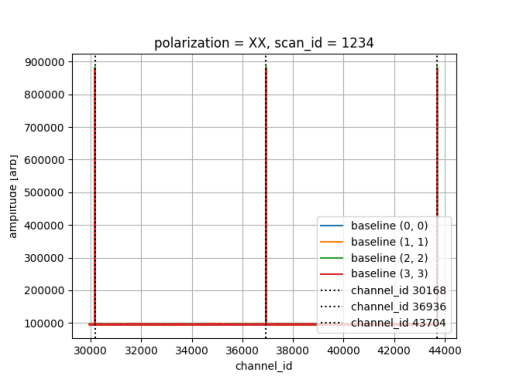

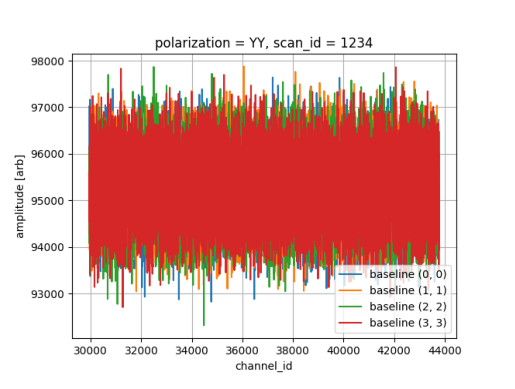

In [74]:
station_baseline_mapping = LowCbfSdpSpeadStationBaselineMapping(CONFIGURE["lowcbf"]["stations"]["stns"])

buf = {
    "xx": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output, station_baseline_mapping.auto_indices,Polarization.XX, scan_id=SCAN_1_ID),
    "yy": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output, station_baseline_mapping.auto_indices,Polarization.YY, scan_id =SCAN_1_ID)
}
for each in buf.values():
    img = Image.open(BytesIO(each))
    plt.imshow(img, aspect="auto")
    plt.axis("off")
    plt.show()

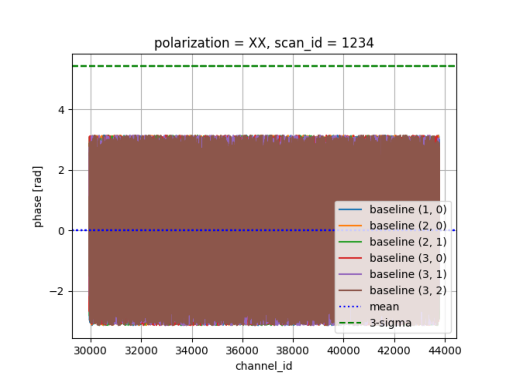

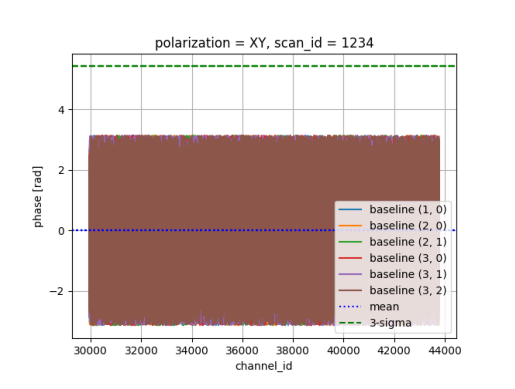

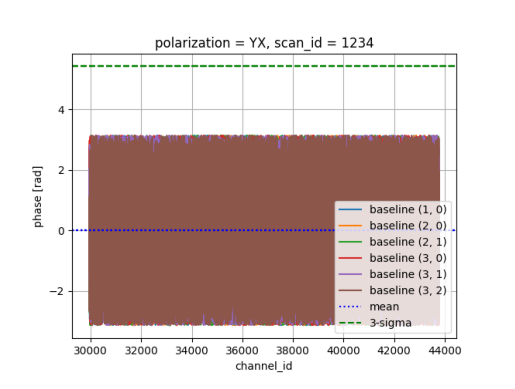

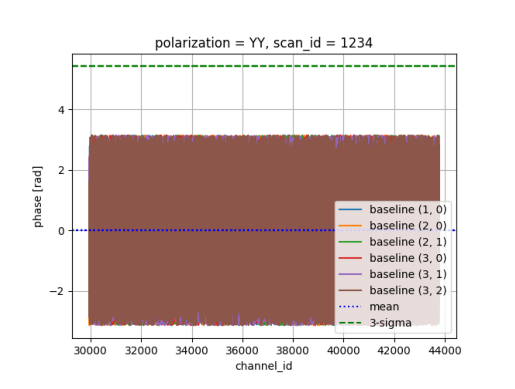

In [75]:
buf = {
    "xx": plotting.plot_time_averaged_phase_vs_channel(pcap_output, station_baseline_mapping.cross_sample(), plotting.Polarization.XX, scan_id=SCAN_1_ID),
    "xy": plotting.plot_time_averaged_phase_vs_channel(pcap_output, station_baseline_mapping.cross_sample(), plotting.Polarization.XY, scan_id=SCAN_1_ID),
    "yx": plotting.plot_time_averaged_phase_vs_channel(pcap_output, station_baseline_mapping.cross_sample(), plotting.Polarization.YX, scan_id=SCAN_1_ID),
    "yy": plotting.plot_time_averaged_phase_vs_channel(pcap_output, station_baseline_mapping.cross_sample(), plotting.Polarization.YY, scan_id=SCAN_1_ID),
}
for each in buf.values():
    img = Image.open(BytesIO(each))
    plt.imshow(img, aspect="auto")
    plt.axis("off")
    plt.show()